# Square (single regular polygon)

We define some scripts to create the cutting patterns for one of the 3 regular tesselations.<br>
In particular for the square

### Strategy

- We define a basic shape made of a triangle using python library [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).<br>
- We fill a portion of the plane with copies of this shape.
- We remove the polygons outside the frame which defines the shape of the riser
- We use the **Shapely** set operation "difference" to trip shapes too close to the edge (leaving some margin for welding the risers)


### Process Overview

<img src="./img/process_overview.png" width="80%">

In [232]:
# Imports
import math

from shapely.geometry import Polygon, box
from shapely import affinity, centroid, polygons

import svgwrite
from svgwrite import mm

import matplotlib.pyplot as plt
import numpy as np

In [233]:
import sys
sys.path.append('../..')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    plot_polygon_list,
    center_rectangle_on_polygons,
    is_polygon_inside_frame,
    save_polygon_list_to_svg
)

## FUNCTION DEFINITIONS

### Canvas and Polygon sizes

In [234]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 176.5
tabica_width = 904.5

INSET_DISTANCE = 3.9   # X ratio gives gaps of about 2Xmm solid channels

band_width = 28 # solid margin, at top of step
side_inset = 22 # solid margin for sides of step

polygon_radius = 23 

### Polygon creation

In [235]:
# Create a square (4 sides)
triangle = create_regular_polygon(0,0, polygon_radius, 4)

### Dictionary of Polygons

Here we save a dictionary of polygons.

The reason for using a dictionary is to be able to plot polygon with its key representing its label.
This allows us to easily visualize the transforms that define the position of the polygon.

In [236]:
# translate_x = 0   # Translate 50mm on the X axis
# translate_y = triangle_radius/2 + hexagon_radius*math.cos(math.pi/6)   # Translate 50mm on the Y axis

rotated_polygon = affinity.rotate(triangle, 90, origin="centroid")

polygon_dict = {}
polygon_dict['T0'] = rotated_polygon
polygon_dict['T1'] = affinity.translate(rotated_polygon, 
                                 +2*polygon_radius,
                                 0)
 
polygon_dict['T2'] = affinity.translate(rotated_polygon, 
                                 +polygon_radius, 
                                 +polygon_radius) 

polygon_dict['T3'] = affinity.translate(rotated_polygon,
                                +3*polygon_radius, 
                                +polygon_radius)

polygon_dict['T4'] = affinity.translate(rotated_polygon, 
                                        +polygon_radius,
                                       +3*polygon_radius)
        

### Plotting Dictionaries of Shapes

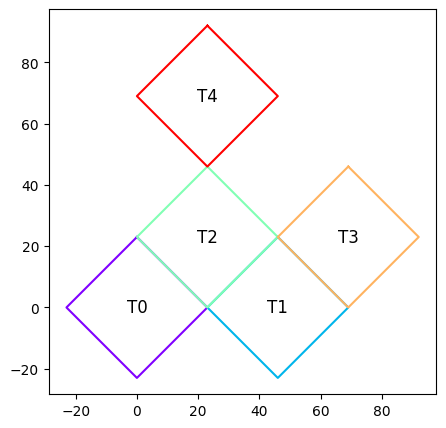

In [237]:
plot_polygon_dict(polygon_dict)

## List of Polygons

In order to generate the full list of polygons that fill the plane, we will store them in a list
instead of a dictionary.  <br>The basic idea is to use the basic initial shape
and apply a series of translations to generate the full list of polygons.

In [238]:
polygon_dict = {}
polygon_dict['T0'] = rotated_polygon
initial_polygon_list = list(polygon_dict.values())

### Plane Translations

We define 2 translations
- **up_t:** For *up* triangles
- **down_t:** For *down* triangles 


In [239]:
def translate_square(initial_square, x, y):
    translated_square = affinity.translate(initial_square, 
                                            + x * 2 * polygon_radius,
                                            0)
    
    translated_square = affinity.translate(translated_square, 
                                 + y * polygon_radius, 
                                 + y * polygon_radius) 
    
    return translated_square

### Plotting Lists of Polygons

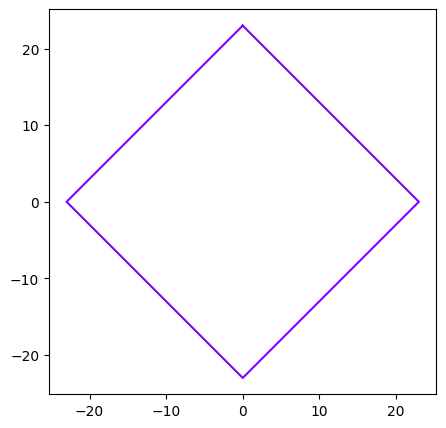

In [240]:
initial_polygon_list = list(polygon_dict.values())
plot_polygon_list(initial_polygon_list)

### Translation Strategy

1. We create a "basic polygon group" made of 2 triangles
   * This column is created by translating the last copied group to the right and up
   * We repeat this process until we have a big enough column (about 8 or 9 copies)

 2. We return to the base of the column, and translate one "basic polygon group" to the right

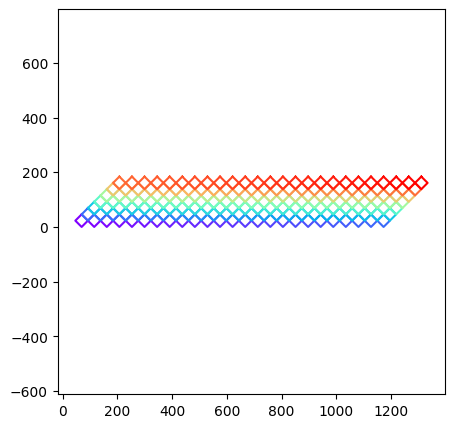

In [241]:
polygon_dict = {}
polygon_dict['T0'] = rotated_polygon
initial_polygon_list = list(polygon_dict.values())
full_polygon_list = []

index_right = 26
index_up = 8

# First create the initial column
for k in range(1, index_up):
    for j in range(1, index_right):
        new_square = [translate_square(rotated_polygon, j, k)]
        full_polygon_list += new_square


plot_polygon_list(full_polygon_list)        

# FRAME

The frame defines the rectangle that will become the cut sheet metal.
We want to delete polygons outside of this frame, and potentially "trim" some of the polygons at the edges,
to ensure the sheet metal can we welded robustly to the next piece.

In [242]:
frame = polygons([[0,0],
                  [0 + tabica_width, 0],
                  [0 + tabica_width, 0 + tabica_height],
                  [0, 0 + tabica_height]])

### Function to center frame around the polygons

In [243]:
# Center the rectangle
centered_frame = center_rectangle_on_polygons(full_polygon_list, frame)

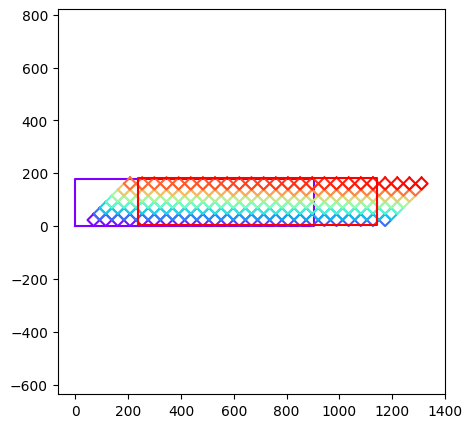

In [244]:
plot_polygon_list([frame] + full_polygon_list + [centered_frame])

### Delete polygons *mostly* outside of frame

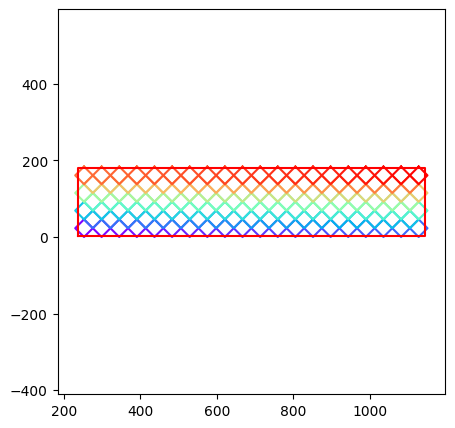

In [245]:
# Filter the full_polygon_list to keep only polygons "mostly" inside the rectangle
# by "mostly" we mean that the centroid of the polygon lies outside the frame.
filtered_polygon_list = [polygon for polygon in full_polygon_list if is_polygon_inside_frame(polygon, centered_frame)]

# Update the full_polygon_list
full_polygon_list = filtered_polygon_list

# Plot the polygons
plot_polygon_list(full_polygon_list + [centered_frame])

## Perform Inset Operation on polygons
This shrinks each polygon to leave some material between them by a specified amount

In [246]:
inset_polygon_list = []
for poly in full_polygon_list:
    inset_polygon_list.append(poly.buffer(-INSET_DISTANCE))



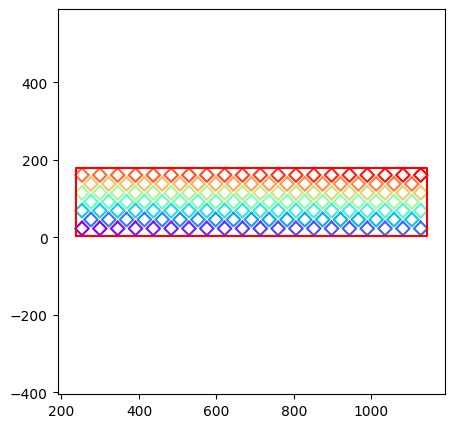

In [247]:
plot_polygon_list(inset_polygon_list + [centered_frame])

## Creating a border with margin  

1. We define some bands around the frame

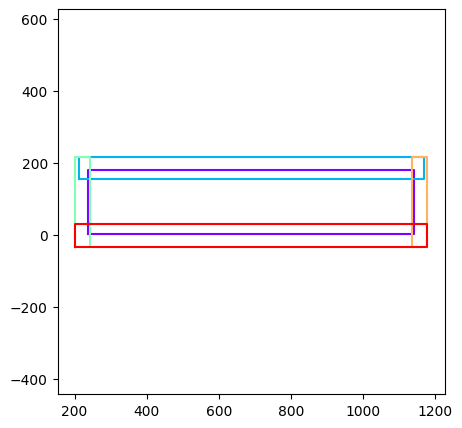

In [248]:

top_band = polygons([[centered_frame.bounds[0] - band_width, centered_frame.bounds[3] - band_width],
                    [centered_frame.bounds[0] - band_width, centered_frame.bounds[3] + band_width + 10],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] + band_width + 10],
                    [centered_frame.bounds[2] + band_width, centered_frame.bounds[3] - band_width]])

left_band = polygons([[centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] - band_width - 10],
                      [centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[0] + band_width - side_inset, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[0] + band_width - side_inset, centered_frame.bounds[1] - band_width - 10]])

right_band = polygons([[centered_frame.bounds[2] - band_width + side_inset, centered_frame.bounds[1] - band_width - 10],
                      [centered_frame.bounds[2] - band_width + side_inset, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[3] + band_width + 10],
                      [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] - band_width - 10]])

bottom_band = polygons([[centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] - band_width - 10],
                        [centered_frame.bounds[0] - band_width - 10, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] + band_width],
                        [centered_frame.bounds[2] + band_width + 10, centered_frame.bounds[1] - band_width - 10]])

plot_polygon_list([centered_frame, top_band, left_band, right_band, bottom_band])

In [249]:
def is_point_inside_rectangle(point, rect):
    """Check if a point is inside a rectangle."""
    x, y = point
    (rx1, ry1, rx2, ry2) = rect.bounds
    return rx1 <= x <= rx2 and ry1 <= y <= ry2

def is_polygon_inside_rectangle(polygon, rect):
    """Check if any vertices of a polygon are inside a rectangle."""
    return any(is_point_inside_rectangle(vertex, rect) for vertex in polygon.exterior.coords)

In [250]:
top_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, top_band)]
left_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, left_band)]
right_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, right_band)]
bottom_band_polygons = [polygon for polygon in inset_polygon_list if is_polygon_inside_rectangle(polygon, bottom_band)]

# deduplicate the list of polygons overlapped by each band:
band_polygons = list(set(top_band_polygons + left_band_polygons + right_band_polygons + bottom_band_polygons))
# keep the polygons outside of bands for later:
all_other_polygons = [polygon for polygon in inset_polygon_list if polygon not in band_polygons]

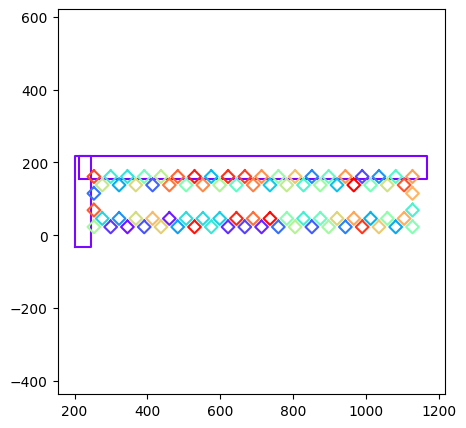

In [251]:
plot_polygon_list([top_band] + [left_band] + band_polygons)

In [252]:
cropped_polygons = []
for poly in band_polygons:
    bit_to_keep_t = poly.difference(top_band)
    bit_to_keep_b = bit_to_keep_t.difference(bottom_band)
    bit_to_keep_l = bit_to_keep_b.difference(left_band)
    bit_to_keep = bit_to_keep_l.difference(right_band)
    cropped_polygons.append(bit_to_keep)


# some polygons are cropped down to nothing (no coordinates), so we need to remove them
cropped_polygons = [poly for poly in cropped_polygons if poly.exterior] 

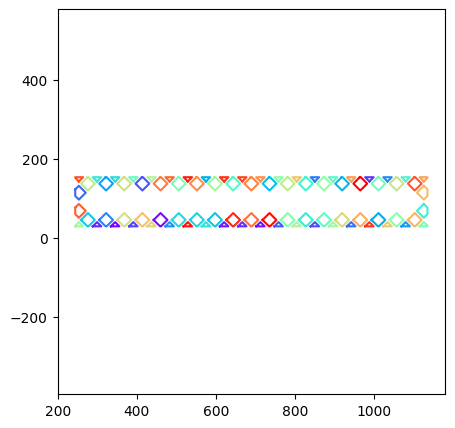

In [253]:
plot_polygon_list(cropped_polygons)

In [254]:
final_polygons =  all_other_polygons + cropped_polygons + [centered_frame]


# SANITY CHECKS

- delete any polygon with an area less than a threshold

In [255]:
len(final_polygons)

138

In [256]:

for poly in final_polygons:
    # pop polygon out of the list if area < 9
    if poly.area < 8:
        final_polygons.remove(poly)
    

In [257]:
len(final_polygons)

138

### Save POLYGONS to SVG

# SAVE


In [258]:
save_polygon_list_to_svg(final_polygons, filename='tramo1.4.svg')

In [259]:
save_polygon_list_to_svg(full_polygon_list, filename='tramo1.4_draft.svg')